# 一、明确目的
本次练习需要围绕以下目的进行：

-  **理解问题** ： 观察每个变量特征的意义以及对于问题的重要程度
-  **研究主要特征** ： 也就是最终的目的变量----房价
-  **研究其他变量** ： 研究其他多变量对“房价”的影响的他们之间的关系
-  **基础的数据清理** ： 对一些缺失数据、异常点和分类数据进行处理
-  **测试假设**

In [6]:
# 导入需要的模块
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns       

from scipy import stats
from scipy.stats import  norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  
# 为了在jupyter notebook里作图，需要用到这个命令

In [4]:
data_train = pd.read_csv("train.csv")

In [7]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

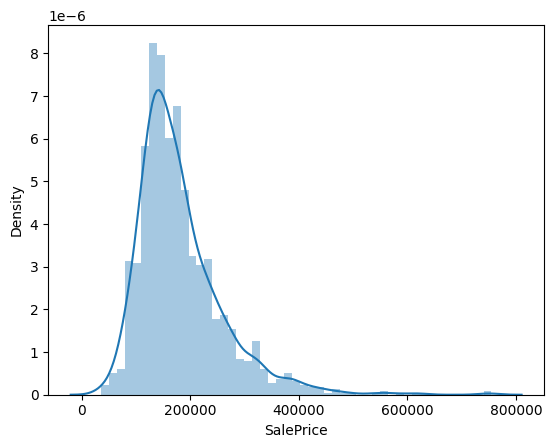

In [10]:
sns.distplot(data_train['SalePrice'])

可以看到与使用matplotlib作的直方图最大的区别在于有一条密度曲线（KDE），可以通过设置参数去掉这条默认的曲线。
另外由上图可以知道房价呈现**正态分布**。下面还可以看到两个统计学中的概念：
**峰度（Kurtosis）**和 **偏度（Skewness）**。

> **峰度：峰度（Kurtosis）是描述某变量所有取值分布形态陡缓程度的统计量。**

>它是和正态分布相比较的。

> - Kurtosis=0 与正态分布的陡缓程度相同。

> - Kurtosis>0 比正态分布的高峰更加陡峭——尖顶峰

> - Kurtosis<0 比正态分布的高峰来得平台——平顶峰计算公式：**β = M_4 /σ^4** 偏度：


> **偏度：偏度（Skewness）是描述某变量取值分布对称性的统计量。**

> - Skewness=0 分布形态与正态分布偏度相同
> - Skewness>0 正偏差数值较大，为正偏或右偏。长尾巴拖在右边。
> - Skewness<0 负偏差数值较大，为负偏或左偏。长尾巴拖在左边。 计算公式：
S= (X^ - M_0)/δ Skewness 越大，分布形态偏移程度越大。

In [11]:
#skewness and kurtosis
print("Skewness: %f" % data_train['SalePrice'].skew())
print("Kurtosis: %f" % data_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


<!-- ![计算峰度](峰度.png) -->
<img src="峰度.png" alt="计算峰度" width="600" height="500">


In [13]:
# 手动计算峰度 

def calKurtosis(data):
    # 计算出均值和标准差
    mean = np.mean(data)
    std_dev = np.std(data) 

    # 计算出每个数据点和均值的差值
    deviations = data - mean
    
    fourth_power_deviations = deviations ** 4
    # 计算四次方差值的平均值
    fourth_moment = np.mean(fourth_power_deviations)
    # 计算峰值
    kurtosis = fourth_moment / (std_dev ** 4) - 3
    return kurtosis 


<img src="偏度.png" alt="计算偏度" width="600" height="500">


In [19]:
# 手动计算偏度

def calSkewness(data) :
    # 计算出均值和标准差
    mean = np.mean(data) 
    dev = np.std(data)

    diff = data - mean 
    diff_three = diff**3 
    diff_three_mean = np.mean(diff_three) 
    skewness = diff_three_mean/ dev**3 
    return skewness

In [14]:
calKurtosis(data_train['SalePrice'])

6.509812011089435

In [20]:
calSkewness(data_train['SalePrice'])

1.8809407460340355

> 因此从上面计算出的峰度和偏度 ，就可以得出 `SalePrice`(房价)的数据分布，峰度>0表明 ，高峰陡峭，长尾巴确实拖在右边


## 2. 分析特征数据

### 2.1 数据再分类
为了让我们对数据的分析更具科学性，我们可以新建一个excel文件，具体需要记录的数据如下：

- **Variable**：变量名
- **Data Type**：各变量的数据类型，分为“数值型--0”和“类别型--1”
- **Segment**：变量的类型。分为：“building--0”、“space--1”、“location--2”。具体解释如下：
    - **building**：比如房屋材料、造型等与房屋物理特性相关的特征（e.g. 'OverallQual'）
    - **space**：即与房屋空间有关的特征，如面积(e.g. 'TotalBsmtSF')
    - **location**：如地段、道路情况等(e.g. 'Neighborhood')
- **Expectation**：表示我们认为该变量对于“SalePrice”的影响程度，划分为“High---3”，“Medium---2”，“Low---1”
- **Conclusion**：与“Expectation”类似，这个表示我们在观察完数据后得出的结论，其实也可和“Expectation”相同。
- **Comments**：其他关于该变量的一些看法

### 2.2 提取主要特征
接下来要做的就是按照上面要求完成电子表单，Go！！！！

我已经完成了任务，下面将会对整理后的数据进一步分析来选出主要影响售价的特征。
- **Utilities**：第一个映入我眼帘的是**Utilities**，因为公共设施越齐全肯定越贵嘛，但是我又观察了具体的训练数据集，发现每一个房屋都是“AllPub”，即都具备基础的公共设施，所以这一项不能入选。
- **LotArea**：英文理解能力有限，并不知道这什么意思，姑且认为是“**地皮面积**”，很好理解，面积越大肯定越贵嘛。。。
- **Neighborhood**：这应表示房屋所处市区的位置，这个必选啊，合不合适在后面再具体分析。
- **OverallQual**：对房子的整体材料和装修进行评估
- **YearBuilt**：建造年份
- **TotalBsmtSF**&**GrLivArea**：训练数据中有很多特征都涉及到了面积，所以没必要每个都考虑进去，为了简化，选择了**TotalBsmtSF（地下室面积）**&**GrLivArea（生活面积）**
- **Heating**：供暖方式应该很重要，但是数据显示基本上都是**GasA**类型，所以不予考虑，
- **CentralAir**：中央空调这个可以考虑一下，因为有的有，有的没有。
- **MiscVal**: 在其他类别中未涉及的其他功能的价值，一般都是“shed（棚子）”，价格在400-1500美元之间，可以考虑一下
- **GarageCars**&**GarageArea**：车库可容纳的车辆数以及其面积，这个可以算成单位车辆拥有的面积来计算

总结起来入选的特征如下：

|Variable|Segment|Data Type|Comments|
|-------|--------|--------|---------|
|**LotArea**| 1 | 0  | 地皮面积|
|**GrLivArea**   | 1  |  0 |生活面积|
|**TotalBsmtSF**   | 1  |  0 |地下室总面积|
|**MiscVal**   | 0  | 0  |其他资产|
|**GarageArea**/**GarageCars** | 1  |  0 |车库|
|**YearBuilt**   | 0  | 1  | 建造年份|
|**CentralAir**   | 0  |  1 |中央空调|
|**OverallQual**   | 0  | 1  |总体评价|
|**Neighborhood**  |  2 |  1 |地段|

如上表所示，入选5个数值型特征，4个分类型特征

## 3.验证主要特征是否满足要求

### 3.1 类别型特征
#### 1. CentralAir 中央空调

> 中央空调 : Y表示有， N表示没有


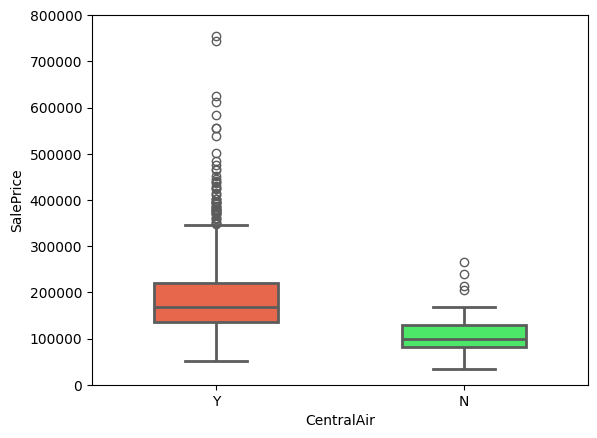

In [22]:
# CentralAir
var = 'CentralAir'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
# 指定自定义配色方案
custom_palette = ["#FF5733", "#33FF57"]  # 自定义颜色列表

# 创建箱型图并设置颜色和样式
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette=custom_palette, width=0.5, linewidth=2)

fig.axis(ymin=0, ymax=800000);

可以很明显的看到有中央空调的房价明显更高。
#### 2. OverallQual 总体评价

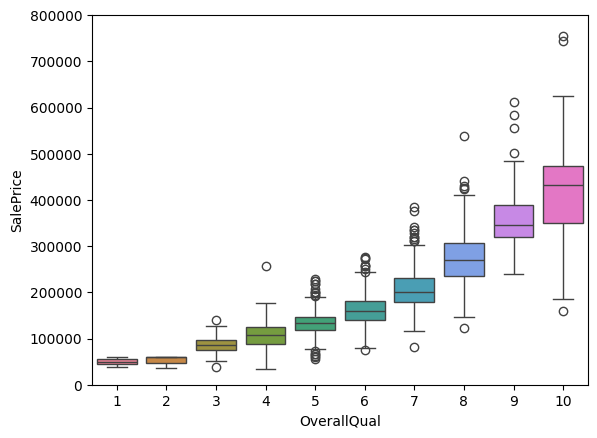

In [25]:
# OverallQual
var = 'OverallQual'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
# 获取数据中不同取值的个数
num_categories = data[var].nunique()

# 自动生成合适数量的颜色
palette = sns.color_palette("husl", num_categories)

fig = sns.boxplot(x=var, y="SalePrice", data=data ,palette=palette)
fig.axis(ymin=0, ymax=800000);

#### 3. YearBuilt 建造年份

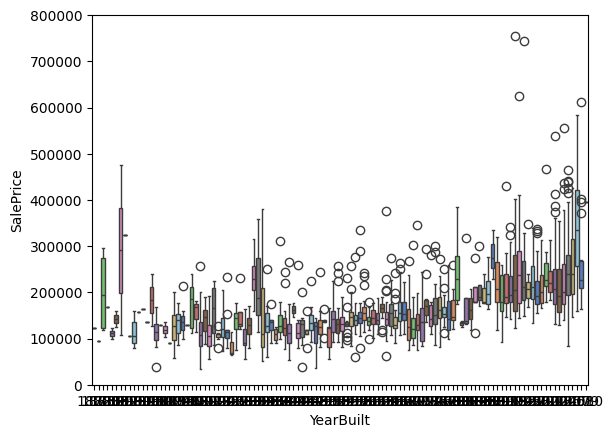

In [27]:
# YearBuilt
var = 'YearBuilt' 
data = pd.concat([data_train['SalePrice'] ,data_train[var]] ,axis=1)

num_year = data_train[var].nunique()
palette = sns.color_palette("muted", num_categories)
fig = sns.boxplot(x=var, y="SalePrice", data=data ,palette=palette)
fig.axis(ymin=0, ymax=800000);


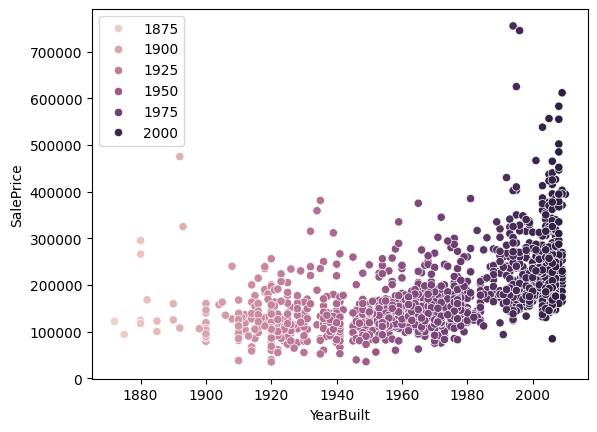

In [41]:
var = 'YearBuilt'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)

# data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))


# 设置坐标轴标签
ax.set_xlabel(var)
ax.set_ylabel("SalePrice")

# 添加标题
ax.set_title(f"Scatter Plot of {var} vs SalePrice")

# 使用Seaborn的scatterplot函数，根据第三个变量设置颜色
sns.scatterplot(x=var, y="SalePrice", data=data, hue=var)
plt.legend(loc='upper left')
plt.show()
# 显示网格线
# ax.grid(True)

In [ ]:
# 1 求出每年的房价均值， 然后画出均值的折线图 ,柱形图


<Axes: xlabel='LotArea', ylabel='SalePrice'>

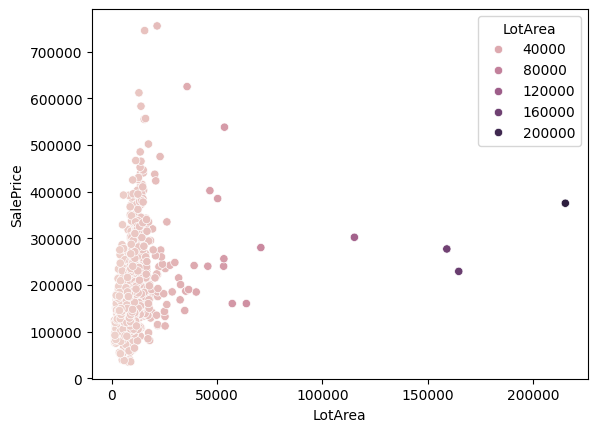

In [44]:
var  = 'LotArea'
# 设置坐标轴标签
ax.set_xlabel(var)
ax.set_ylabel("SalePrice")
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
sns.scatterplot(x=var,y='SalePrice',data=data,hue=var)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

**从图上看，好像没什么关系**

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

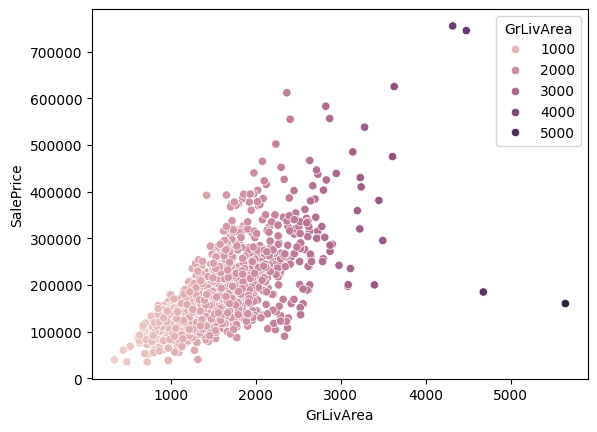

In [49]:
var  = 'GrLivArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
# 设置坐标轴标签
ax.set_xlabel(var)
ax.set_ylabel("SalePrice")
sns.scatterplot(x=var,y='SalePrice',data=data,hue=var)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

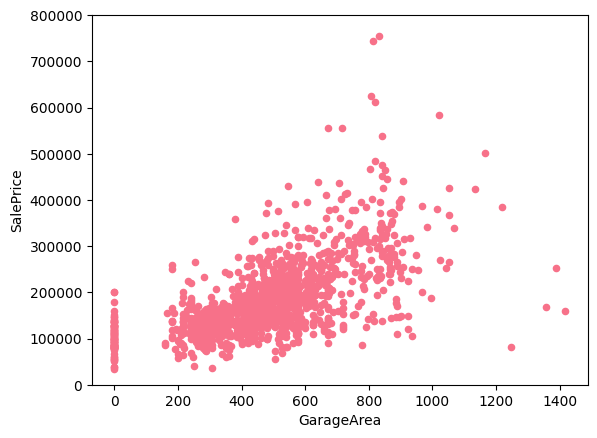

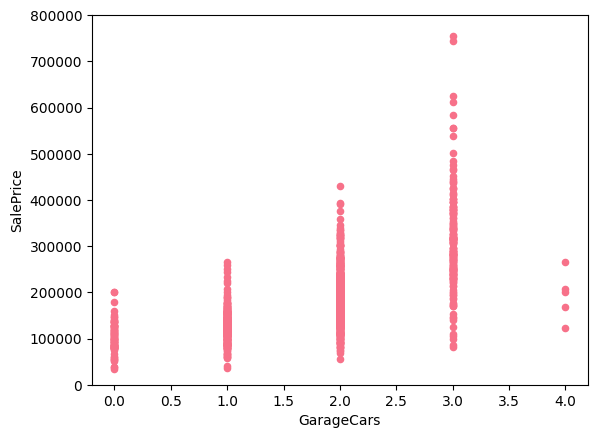

In [51]:
var  = ['GarageArea', 'GarageCars']
for index in range(2):
    data = pd.concat([data_train['SalePrice'], data_train[var[index]]], axis=1)
    data.plot.scatter(x=var[index], y='SalePrice', ylim=(0, 800000))

由上面点图可以看出房价与车库面积和容纳车辆数呈现线性关系，所以入选主要特征。

## 4. 主要特征
总结起来，最后

|Variable|Segment|Data Type|Comments|
|-------|--------|--------|---------|
|**GrLivArea**   | 1  |  0 |生活面积|
|**TotalBsmtSF**   | 1  |  0 |地下室总面积|
|**GarageArea**/**GarageCars** | 1  |  0 |车库|
|**YearBuilt**   | 0  | 1  | 建造年份|
|**CentralAir**   | 0  |  1 |中央空调|
|**OverallQual**   | 0  | 1  |总体评价|
|**Neighborhood**  |  2 |  1 |地段|

# 三、更加科学的分析数据

上面的分析可以说非常主观，所以说多多少少还是会不放心，会担心自己选择的特征会不会多了或者少了，又或者选了一些没有太大作用的特征，所以接下来需要进行更加科学的分析。

为了做到更加科学，我们需要作如下工作：
- 得到各个特征之间的关系矩阵（**correlation matrix**）
- 'SalePrice'的关系矩阵
- 绘制出最相关的特征之间的关系图

## 3.1 关系矩阵

<Axes: >

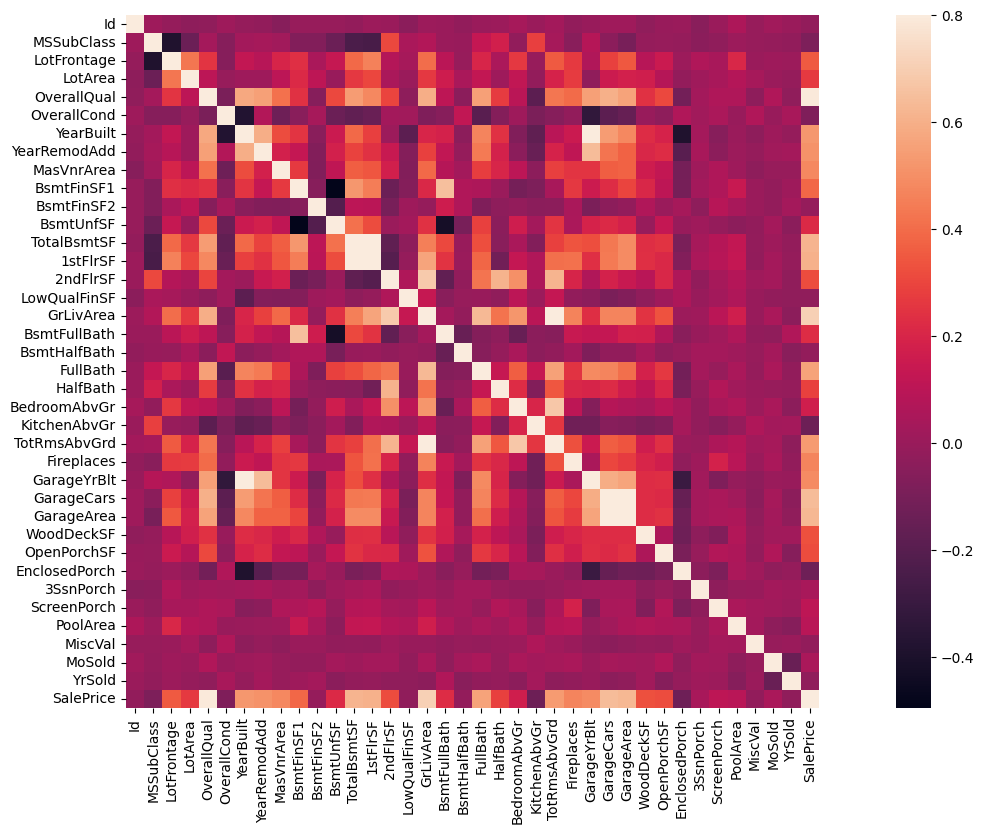

In [52]:
numeric_corrmat = data_train.select_dtypes(include=[np.number]).corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(numeric_corrmat, vmax=0.8, square=True)


<Axes: >

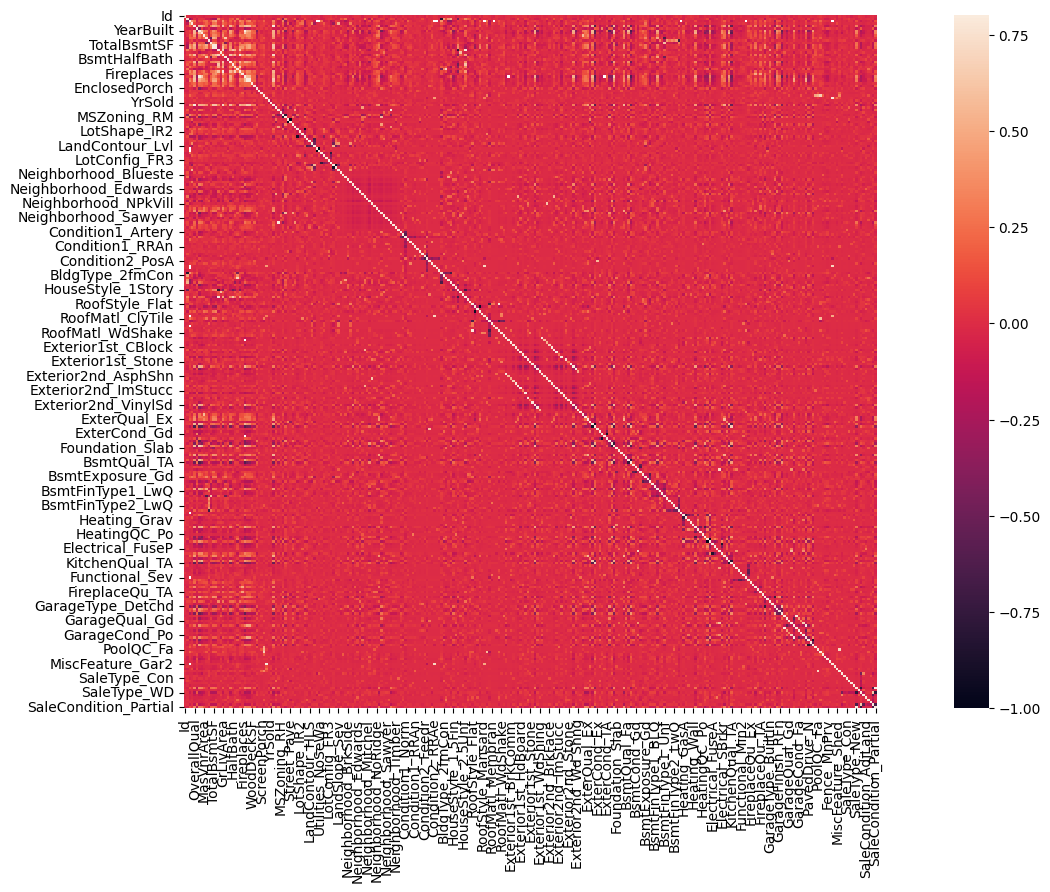

In [53]:
# 例如，使用独热编码将分类数据转换为数值型数据
data_train_encoded = pd.get_dummies(data_train)

# 计算相关性矩阵
corrmat_encoded = data_train_encoded.corr()

# 绘制热图
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat_encoded, vmax=0.8, square=True)


In [55]:
# corrmat = data_train.corr()
k  = 10 # 关系矩阵中将显示10个特征
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

ValueError: could not convert string to float: 'RL'